In [1]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_name = 'Skin Cancer (HAM10000)'
dst_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja'  # This will place it in the content directory

import tarfile

# Specify the path to your tar file in Google Drive
tarfile_path = '/content/drive/MyDrive/skin-cancer-ham10000-DatasetNinja.tar'

# Create the destination directory if it doesn't exist
!mkdir -p "$dst_dir"

# Extract the dataset
with tarfile.open(tarfile_path, 'r') as tar_ref:
    tar_ref.extractall(dst_dir)

In [6]:
import os
import pandas as pd
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from torchvision.io import read_image
import segmentation_models_pytorch as smp
from torchvision import transforms
import random
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import segmentation_models_pytorch as smp
import torch.optim as optim
import poutyne as pyt
from poutyne.framework.callbacks import ModelCheckpoint, EarlyStopping

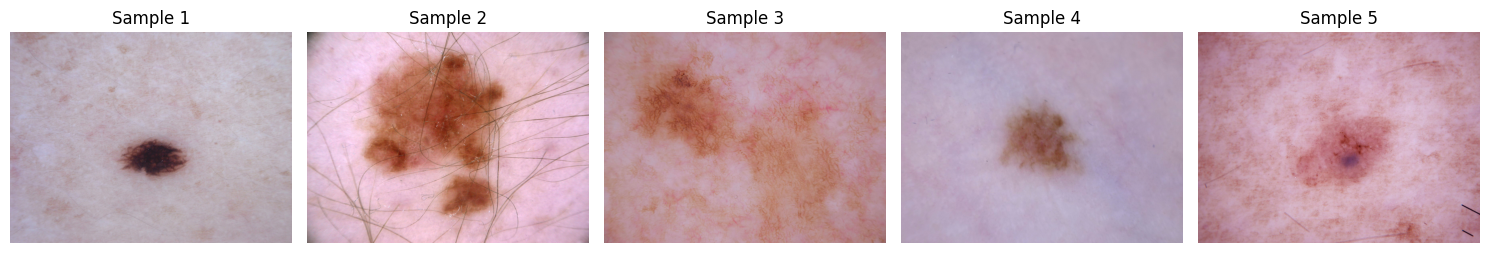

In [7]:
# Define the paths to the image and annotation directories
image_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/img/'
annotation_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/ann/'

# Get a list of image files in the directory
image_files = os.listdir(image_dir)

# Randomly select and display a few sample images
num_samples = 5
sample_image_files = random.sample(image_files, num_samples)

# Create subplots to display sample images
plt.figure(figsize=(15, 5))
for i, image_file in enumerate(sample_image_files):
    # Load the image
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    # Convert BGR images to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image_rgb)
    plt.title(f'Sample {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# Define the directory containing the dataset
dataset_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/img'

# Get a list of all image filenames
image_filenames = os.listdir(dataset_dir)

# Shuffle the list to ensure randomness
random.seed(42)  # For reproducibility
random.shuffle(image_filenames)

# Define the proportions for the train, validation, and test splits
train_split_ratio = 0.8
val_split_ratio = 0.1
test_split_ratio = 0.1

# Calculate the number of samples for each split
total_samples = len(image_filenames)
train_samples = int(total_samples * train_split_ratio)
val_samples = int(total_samples * val_split_ratio)
test_samples = total_samples - train_samples - val_samples

# Split the dataset into train, validation, and test sets
train_images = image_filenames[:train_samples]
val_images = image_filenames[train_samples:train_samples + val_samples]
test_images = image_filenames[train_samples + val_samples:]

# Define the target dimensions (divisible by 32)
target_height = 480
target_width = 640

# Define a function to pad the image to the target dimensions
def pad_image(image):
    width, height = image.size

    # Calculate the padding size
    pad_height = target_height - height
    pad_width = target_width - width

    # Calculate the padding on each side
    top_pad = pad_height // 2
    bottom_pad = pad_height - top_pad
    left_pad = pad_width // 2
    right_pad = pad_width - left_pad

    # Ensure a valid color tuple
    color = (0,)  # Default color for padding, a single-element tuple

    # Apply padding
    padded_image = Image.new(image.mode, (target_width, target_height), color)
    padded_image.paste(image, (left_pad, top_pad))

    return padded_image

import os
import json
import numpy as np
from PIL import Image

# Define the directory containing the JSON annotation files
annotation_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/ann'
mask_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/masks'

# Create the mask directory if it doesn't exist
os.makedirs(mask_dir, exist_ok=True)

# Iterate through JSON annotation files
for json_file in os.listdir(annotation_dir):
    if json_file.endswith('.json'):
        print(f"Processing {json_file}")
        with open(os.path.join(annotation_dir, json_file), 'r') as f:
            annotation_data = json.load(f)

        # Extract information from the JSON annotation (adapt this part to your data)
        image_width = target_width
        image_height = target_height
        mask_data = annotation_data.get('data', [])  # Replace 'data' with the correct field name for mask data, providing a default empty list if not found

        # Create a mask image (adapt this part to your data)
        mask_image = Image.new('L', (image_width, image_height), 0)
        for mask_region in mask_data:
            # Convert mask region to NumPy array or other suitable format
            mask_region_np = np.array(mask_region)
            mask_region_image = Image.fromarray(mask_region_np)
            mask_image = Image.alpha_composite(mask_image, mask_region_image)

        # Save the mask image
        mask_image.save(os.path.join(mask_dir, json_file.replace('.json', '.png')))

# Modify your dataset class to load the mask images
class SkinCancerDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_list, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_list[idx])
        # Adjust the way you construct the mask filename
        mask_name = os.path.join(self.mask_dir, os.path.basename(img_name).replace('.jpg', '.jpg.png'))
        image = Image.open(img_name)
        mask = Image.open(mask_name)  # Load the corresponding mask

        # Pad the image and mask to the target dimensions
        image = pad_image(image)
        mask = pad_image(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask  # Return the input image and the mask image


# Define image transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize(224)
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize for grayscale image
])

# Create datasets and data loaders for train, validation, and test sets
train_dataset = SkinCancerDataset(dataset_dir, mask_dir, train_images, transform=transform)
val_dataset = SkinCancerDataset(dataset_dir, mask_dir, val_images, transform=transform)
test_dataset = SkinCancerDataset(dataset_dir, mask_dir, test_images, transform=transform)

batch_size = 8  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Check the number of samples in each split
print(f"Total samples: {total_samples}")
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Streaming output truncated to the last 5000 lines.
Processing ISIC_0030271.jpg.json
Processing ISIC_0033374.jpg.json
Processing ISIC_0025206.jpg.json
Processing ISIC_0026930.jpg.json
Processing ISIC_0034070.jpg.json
Processing ISIC_0028893.jpg.json
Processing ISIC_0030493.jpg.json
Processing ISIC_0029285.jpg.json
Processing ISIC_0026460.jpg.json
Processing ISIC_0024614.jpg.json
Processing ISIC_0025814.jpg.json
Processing ISIC_0026393.jpg.json
Processing ISIC_0025487.jpg.json
Processing ISIC_0029299.jpg.json
Processing ISIC_0028981.jpg.json
Processing ISIC_0030756.jpg.json
Processing ISIC_0034102.jpg.json
Processing ISIC_0025043.jpg.json
Processing ISIC_0033414.jpg.json
Processing ISIC_0029935.jpg.json
Processing ISIC_0031891.jpg.json
Processing ISIC_0032872.jpg.json
Processing ISIC_0031672.jpg.json
Processing ISIC_0031592.jpg.json
Processing ISIC_0028058.jpg.json
Processing ISIC_0032136.jpg.json
Processing ISIC_0024456.jpg.json
Processing ISIC_0027700.jpg.json
Processing ISIC_0026000.j

In [9]:
# Directory containing the mask files
mask_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/masks'

# List all files in the mask directory
mask_files = os.listdir(mask_dir)

# Count the number of mask files
num_mask_files = len(mask_files)

# Print the count
print(f"Number of mask files in the directory: {num_mask_files}")

Number of mask files in the directory: 10015


In [10]:
# Define a dataset class for segmentation
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, transform=None):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        annotation = Image.open(self.annotation_paths[idx])

        if self.transform:
            image = self.transform(image)
            annotation = self.transform(annotation)

        return image, annotation

In [11]:
# Define paths to images and annotations
images_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/img'  # Updated to the img directory
annotations_dir = '/content/Skin Cancer (HAM10000)/dataset-ninja/ds/masks'  # Updated to the masks directory

# Get lists of image and mask file names
image_file_names = os.listdir(images_dir)
mask_file_names = os.listdir(annotations_dir)

# Ensure consistent ordering of files
image_file_names.sort()
mask_file_names.sort()

# Exclude unlabeled images (assuming they have no corresponding masks)
labeled_image_file_names = [filename for filename in image_file_names if filename in mask_file_names]

# Shuffle the list to ensure randomness
random.seed(42)
random.shuffle(labeled_image_file_names)

# Group the filenames by class (assuming filenames follow a pattern)
class_to_files = {}
for filename in labeled_image_file_names:
    class_name = filename.split("_")[1]  # Assuming class name is part of the filename
    if class_name not in class_to_files:
        class_to_files[class_name] = []
    class_to_files[class_name].append(filename)

# Initialize lists for train, validation, and test data
X_train = []
X_val = []
X_test = []

# Split each class into train, validation, and test sets while maintaining balance
for class_name, class_files in class_to_files.items():
    train_files, temp_files = train_test_split(class_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    X_train.extend(train_files)
    X_val.extend(val_files)
    X_test.extend(test_files)

# Define corresponding annotation file paths (mask images)
y_train = [os.path.join(annotations_dir, filename.replace('.jpg', '_mask.png')) for filename in X_train]
y_val = [os.path.join(annotations_dir, filename.replace('.jpg', '_mask.png')) for filename in X_val]
y_test = [os.path.join(annotations_dir, filename.replace('.jpg', '_mask.png')) for filename in X_test]

In [12]:
batch_size = 8

# Use CUDA to leverage the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create DataLoader instances for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define UNet++ model with ResNet18 encoder
model = smp.UnetPlusPlus(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,  # Input channels (RGB image)
    classes=7  # Number of classes in your dataset
)

# Define loss function for segmentation
segmentation_loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
metrics = ['iou', 'dice']

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 158MB/s] 


In [13]:
from tqdm import tqdm

# Define a directory to save checkpoints
checkpoint_dir = '/content/checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a Poutyne model
poutyne_model = pyt.Model(model, optimizer, segmentation_loss_fn).to(device)

callbacks = [
    pyt.ModelCheckpoint("best_model.pth", monitor="val_loss", save_best_only=True),
    pyt.EarlyStopping(monitor="val_loss", patience=10)
]

num_classes = 7

# Training loop
num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]: Training...")

    # Training loop
    model.train()
    train_loss = 0.0

    # Wrap the train_loader with tqdm for a progress bar
    with tqdm(train_loader, unit="batch") as t:
        for batch_idx, batch in enumerate(t):
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Use the second element (mask) as targets

            # Reshape the targets to [batch_size, num_classes, height, width]
            targets = targets.unsqueeze(1)  # Add a channel dimension (1) for class labels

            optimizer.zero_grad()  # Clear gradients
            outputs = model(inputs)  # Forward pass

            # Reshape the outputs to [batch_size, num_classes, height, width]
            outputs = outputs.permute(0, 2, 3, 1)

            # Flatten the targets and outputs for computing the loss
            targets = targets.view(-1)
            outputs = outputs.reshape(-1, num_classes)

            targets = targets.long()  # Convert to long tensor

            loss = segmentation_loss_fn(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights

            train_loss += loss.item() * inputs.size(0)  # Accumulate loss

            t.set_description(f"Epoch [{epoch + 1}/{num_epochs}]: Training - Loss: {loss.item():.4f}")

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader.dataset)

    # Validation loop
    print(f"Epoch [{epoch + 1}/{num_epochs}]: Validating...")
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for validation
        for batch_idx, batch in enumerate(val_loader):
            inputs, targets = batch[0].to(device), batch[1].to(device)  # Use the second element (mask) as targets

            # Reshape the targets to [batch_size, num_classes, height, width]
            targets = targets.unsqueeze(1)  # Add a channel dimension (1) for class labels

            outputs = model(inputs)  # Forward pass

            # Reshape the outputs to [batch_size, num_classes, height, width]
            outputs = outputs.permute(0, 2, 3, 1)

            # Flatten the targets and outputs for computing the loss
            targets = targets.view(-1)
            outputs = outputs.reshape(-1, num_classes)

            loss = segmentation_loss_fn(outputs, targets)  # Compute loss

            val_loss += loss.item() * inputs.size(0)  # Accumulate loss

    # Calculate average validation loss for the epoch
    val_loss /= len(val_loader.dataset)

    # Print the training and validation loss for the epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

# Save the final model
poutyne_model.save_model('/content/final_model.pth')

Epoch [1/10]: Training...


  0%|          | 0/1002 [00:07<?, ?batch/s]


RuntimeError: ignored

In [ ]:
# Define functions to calculate IoU and Dice metrics
def calculate_iou(y_true, y_pred):
    intersection = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()
    iou = (intersection.float() + 1e-6) / (union.float() + 1e-6)
    return iou.item()

def calculate_dice(y_true, y_pred):
    intersection = (y_true & y_pred).sum()
    dice = (2.0 * intersection.float() + 1e-6) / (y_true.sum().float() + y_pred.sum().float() + 1e-6)
    return dice.item()

# Define a function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    iou_scores = []
    dice_scores = []
    total_loss = 0.0  # Initialize total loss

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            predictions = (outputs > 0.5).float()

            iou_batch = []
            dice_batch = []

            for i in range(len(inputs)):
                iou = calculate_iou(targets[i], predictions[i])
                dice = calculate_dice(targets[i], predictions[i])
                iou_batch.append(iou)
                dice_batch.append(dice)

            iou_scores.extend(iou_batch)
            dice_scores.extend(dice_batch)

            # Calculate loss for the batch and accumulate
            batch_loss = segmentation_loss_fn(outputs, targets.argmax(dim=1))
            total_loss += batch_loss.item() * inputs.size(0)

    model.train()

    avg_iou = np.mean(iou_scores)
    avg_dice = np.mean(dice_scores)
    avg_loss = total_loss / len(dataloader.dataset)

    return avg_loss, avg_iou, avg_dice


In [ ]:
model = model.to(device)
inputs = inputs.to(device)

# Define a function to plot images with annotations (ann)
def plot_images_with_annotations(images, annotations_gt, annotations_pred):
    num_samples = len(images)
    fig, axes = plt.subplots(nrows=num_samples, ncols=3, figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Display the test image
        axes[i, 0].set_title('Test Image')

        axes[i, 1].imshow(annotations_gt[i].squeeze(), cmap='gray')  # Display the ground truth annotations
        axes[i, 1].set_title('Ground Truth Annotations')

        axes[i, 2].imshow(annotations_pred[i].squeeze(), cmap='gray')  # Display the predicted annotations
        axes[i, 2].set_title('Predicted Annotations')

    plt.tight_layout()
    plt.show()

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    predictions = (outputs > 0.5).float()

    # Process the batch here

    if len(inputs) < batch_size:
        break  # Break after processing the last batch

# Calculate IoU, Dice, and loss on the test dataset
avg_loss, iou, dice = evaluate_model(model, test_loader)
print(f"IoU: {iou}, Dice: {dice}, Test Loss: {avg_loss}")

# Plot the images and annotations
plot_images_with_annotations(inputs.cpu(), targets.cpu(), predictions.cpu())

NameError: ignored